In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Run a script to structure the image data into a training, validation, and testing folder.
os.chdir('/Users/sivamagarwalla/Downloads/Sign-Language-Digits-Dataset')
if os.path.isdir('train/0') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    
    for i in range(0, 10):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')
        
        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')
            
        test_samples = random.sample(os.listdir(f'train/{i}'), 10)
        for j in test_samples:
            shutil.move(f'train/{i}/{j}', f'test/{i}')

In [5]:
# Set the path to each of the folders containing the image data
train_path = '/Users/sivamagarwalla/Downloads/Sign-Language-Digits-Dataset/train'
valid_path = '/Users/sivamagarwalla/Downloads/Sign-Language-Digits-Dataset/valid' 
test_path = '/Users/sivamagarwalla/Downloads/Sign-Language-Digits-Dataset/test' 

In [7]:
# Creating batches of size 10 for each of the three data categories. Set the shuffle functionality of the training set to false.
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path, target_size=(224, 224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224, 224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path, target_size=(224, 224), batch_size=10, shuffle=False)

Found 1662 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


In [19]:
# Load in the Mobile Net model and inspect it's structure.
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [20]:
# We can all the layers of the model up and including the 6th to last layer. Then we set the output layer to a Dense layer with 
# 10 units, one for each of the classes in the data.
x = mobile.layers[-6].output
output = Dense(units=10, activation='softmax')(x)

model = Model(inputs=mobile.input, outputs=output)

# Set all the layers trainability to false besides the last 23. This 23 mark can be further experimented with to fine tune the MobileNet model
# even more for our dataset.
for layer in model.layers[:-23]:
    layer.trainable = False

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [21]:
# Compile the model, and then run it for 30 epochs.
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x=train_batches, validation_data = valid_batches, epochs=30, verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 167 steps, validate for 30 steps
Epoch 1/30
167/167 - 46s - loss: 0.8687 - accuracy: 0.7407 - val_loss: 1.5742 - val_accuracy: 0.5300
Epoch 2/30
167/167 - 43s - loss: 0.1348 - accuracy: 0.9850 - val_loss: 1.2573 - val_accuracy: 0.4967
Epoch 3/30
167/167 - 42s - loss: 0.0469 - accuracy: 0.9994 - val_loss: 0.9735 - val_accuracy: 0.6400
Epoch 4/30
167/167 - 42s - loss: 0.0247 - accuracy: 1.0000 - val_loss: 0.8203 - val_accuracy: 0.7333
Epoch 5/30
167/167 - 42s - loss: 0.0162 - accuracy: 1.0000 - val_loss: 0.7762 - val_accuracy: 0.7267
Epoch 6/30
167/167 - 42s - loss: 0.0115 - accuracy: 1.0000 - val_loss: 0.7688 - val_accuracy: 0.7267
Epoch 7/30
167/167 - 42s - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.6794 - val_accuracy: 0.7600
Epoch 8/30
167/167 - 42s - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.6509 - val_accuracy: 0.7833
Epoch 9/30
167/167 - 43s - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.6261 - val_accuracy: 0.793

In [22]:
# Now we are going to use the test data to test the model. After running the .predict() function. We then use these predictions 
# to create a confusion matrix to better visualize our results.
test_labels = test_batches.classes
predictions = model.predict(x=test_batches, verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[10  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  1  8  0  0  0  0  1  0  0]
 [ 0  0  2  8  0  0  0  0  0  0]
 [ 0  0  0  0  7  1  1  1  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  2  0  8  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  1  0  0  3  6  0]
 [ 0  0  2  0  0  0  0  1  2  5]]


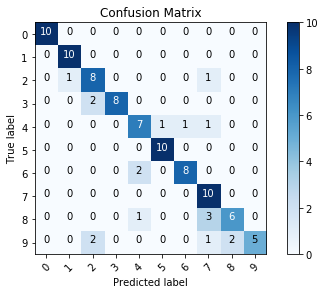

In [24]:
# Plot the confusion matrix. We can see that the testing accuracy is similar to the validation accuracy our model achieved after training.
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')